In [1]:
%pylab inline 
import seaborn as sns
import networkx as nx
import powerlaw
from scipy import stats

import sys
sys.path += ['../src/']

from utils_network import generate_network

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# load network
G = nx.read_edgelist("../data/copenhagen_network_study/fb_friends.csv", delimiter=",", comments='#',
                    nodetype=int)
G = nx.relabel_nodes(G, {node:i for i, node in enumerate(G.nodes())})

G.number_of_nodes(), G.number_of_edges(), np.mean([deg for node, deg in G.degree()])

(800, 6429, 16.0725)

In [5]:
# build an ER network with same nodes and number of edges
# it is as comparison since all experiments run with ER graph
N = G.number_of_nodes()
#p = 6429 / (N * (N - 1) / 2)
p = 20 / (N - 1)
G_rand = nx.fast_gnp_random_graph(N, p, seed=42)

G_rand.number_of_nodes(), G_rand.number_of_edges(), (N - 1) * p

(800, 8025, 20.0)

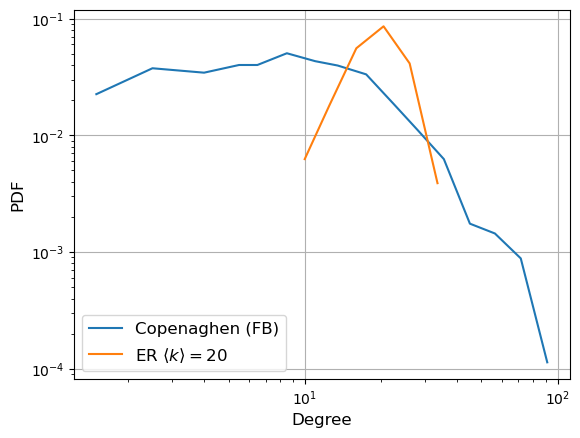

In [8]:
# plot degree distribution
powerlaw.plot_pdf([deg for node, deg in G.degree()], label='Copenaghen (FB)')
powerlaw.plot_pdf([deg for node, deg in G_rand.degree()], label=r'ER $\left< k \right> = 20$')

plt.xlabel("Degree", fontsize=12)
plt.ylabel("PDF", fontsize=12)
plt.legend(fontsize=12)
plt.grid()

The degree distribution is very different. The FB network has a plateau until k=20 and then it decreases. It means that most of the nodes have degree up to k=20, with few users with higher degree.

Text(0, 0.5, '$\\left<k_{NN}\\right>$')

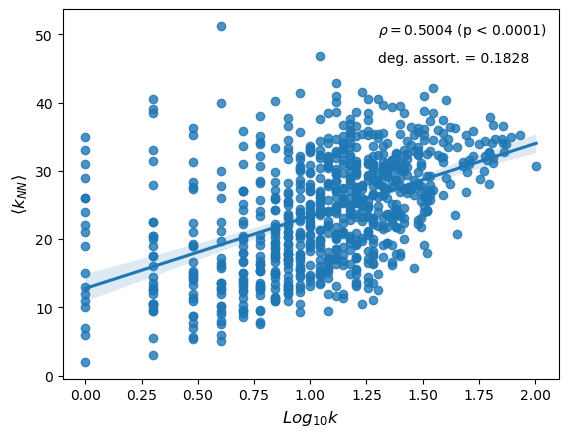

In [9]:
degree_assort = np.array([(deg, knn) for( _, deg), (_, knn) in zip(G.degree(G.nodes()), 
                                     nx.average_neighbor_degree(G, nodes=G.nodes()).items())])

#plt.plot(degree_assort[:, 0], degree_assort[:, 1], 'o')
sns.regplot(x=np.log10(degree_assort[:, 0]), y=degree_assort[:, 1])
rho, p = stats.spearmanr(np.log10(degree_assort[:, 0]), degree_assort[:, 1])
p = f"p = {round(p, 4)}" if p >= 0.0001 else "p < 0.0001"

deg_assort = nx.degree_assortativity_coefficient(G)

plt.text(1.3, 50, fr"$\rho = {round(rho, 4)}$ ({p})")
plt.text(1.3, 46, fr"deg. assort. = {round(deg_assort, 4)}")

plt.xlabel(r"$Log_{10} k$", fontsize=12)
plt.ylabel(r"$\left<k_{NN}\right>$", fontsize=12)

In [6]:
# friendship paradox magnitude
degs = [deg for node, deg in G.degree()]
np.var(degs) / np.mean(degs)

11.142463446881315

The network shows degree assortativity and the degree of nodes is positively correlated with the average degree of the neighbors. This means that high degree nodes are likely to be connected with other high degree nodes.

However, the friendship paradox is not so strong.

In [8]:
# take the network and assign experts at random
# draw distribution of average degree of experts

RNG = np.random.RandomState(42)
N = 800
frac_exp = 0.1
Ne = int(N*frac_exp)
Na = N - Ne

kk = []
for _ in range(100):
    A = generate_network(N, Ne, 
                         network_params="empirical_../data/copenhagen_network_study/fb_friends.csv",
                        seed=RNG)
    k_exp_avg = np.asarray(A.sum(axis=1)).flatten()[Na:].max()
    kk.append(k_exp_avg)

(array([ 1.,  4.,  4., 18., 14., 27., 13., 10.,  0.,  9.]),
 array([ 41.,  47.,  53.,  59.,  65.,  71.,  77.,  83.,  89.,  95., 101.]),
 <BarContainer object of 10 artists>)

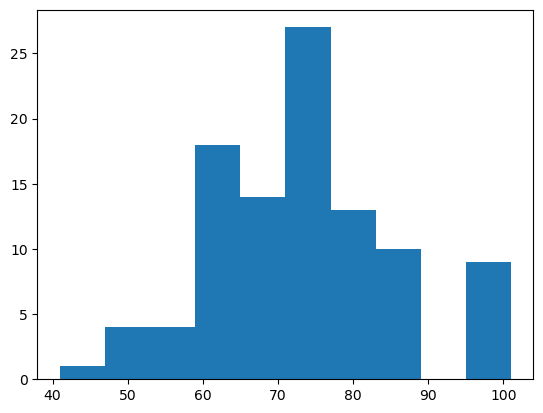

In [9]:
plt.hist(kk)

### Try some runs of the model

In [23]:
from utils_model import initialize_model, score_opinion_updates, rmsd_from_truth
from tqdm.notebook import tqdm
from scipy import sparse

In [24]:
def update_opinions(Xa, Xe, eps_a, eps_e, alpha_e, tau, A):
    Na = Xa.shape[0]
    X_all = np.hstack([Xa, Xe])
    Xe = Xe[:, np.newaxis]
    eps_all = np.hstack([eps_a, eps_e])[:, np.newaxis]
    eps_e = eps_e[:, np.newaxis]
    alpha_e = alpha_e[:, np.newaxis]

    # TODO:
    # -  is it possible to make it even faster?
    # √ manage divisions by 0 (only Xa can encounter divisions by zero)

    # compute if pairwise differences of opinions under the confidence
    delta_opinions_thresholded = sparse.csr_matrix(np.abs(np.subtract.outer(X_all, X_all)) \
                                                   <= eps_all).astype(int)

    # update Xa
    delta_opinions_thresholded_neigs = delta_opinions_thresholded.multiply(A)
    Xa_new = np.asarray(delta_opinions_thresholded_neigs * X_all[:, np.newaxis]).flatten()
    n_neigs = np.asarray(delta_opinions_thresholded_neigs.sum(axis=1)).flatten()
    Xa_new = np.where(n_neigs == 0, X_all, Xa_new / n_neigs)
    Xa_new = Xa_new[:Na]

    # update Xe
    delta_opinions_thresholded = delta_opinions_thresholded[Na:, Na:]
    Xe_new = np.asarray(delta_opinions_thresholded * Xe / delta_opinions_thresholded.sum(axis=1))
    Xe_new = np.where((np.abs(Xe_new - tau) <= eps_e), # check who is close to the truth
                      alpha_e * tau + (1 - alpha_e) * Xe_new, 
                      Xe_new).flatten()

    return Xa_new, Xe_new

In [89]:
# set input params
N = 800
frac_experts = 0.05
tau = 1

Ne = int(N * frac_experts)
Na = N - Ne

# generate syntetic network
network_params = "empirical_../data/copenhagen_network_study/fb_friends.csv"
#network_params = "ER_20"
A = generate_network(N, Ne, network_params, seed=RNG)

# initialize opinions and confidences

init_opinions_params = 'uniform'
init_confidence_params = 'const_0.45'
init_alpha_experts_params = 'const_0.45'
Xa, Xe, eps_a, eps_e, alpha_e = initialize_model(Na, Ne, init_opinions_params, 
                                                 init_confidence_params, init_alpha_experts_params, seed=RNG)

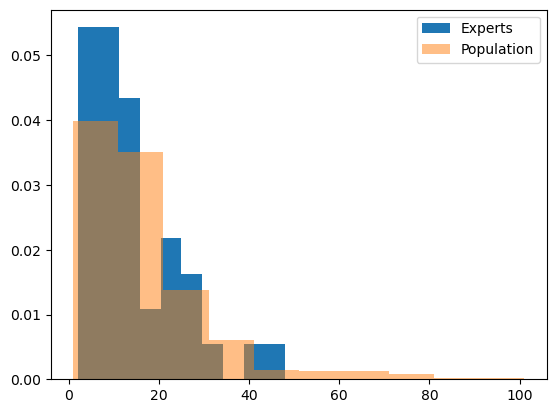

In [90]:
plt.hist(np.asarray(A.sum(axis=1)).flatten()[Na:], density=True, label='Experts')
plt.hist(np.asarray(A.sum(axis=1)).flatten()[:Na], density=True, alpha=0.5, label='Population')

plt.legend()

In [91]:
MAX_STEPS = 300
CONVERGENCE_THRESHOLD = 1e-3
opinions = [np.hstack([Xa, Xe]).tolist()]
rmsd_truth_a = []
rmsd_truth_e = []
rmsd_truth_all = []
for n_iter in tqdm(range(MAX_STEPS), total=MAX_STEPS):
    
    # update opinions
    Xa_new, Xe_new = update_opinions(Xa, Xe, eps_a, eps_e, alpha_e, tau, A)
    
    opinions.append(np.hstack([Xa_new, Xe_new]).tolist())
    
    rmsd_truth_a.append(rmsd_from_truth(Xa_new, tau))
    rmsd_truth_e.append(rmsd_from_truth(Xe_new, tau))
    rmsd_truth_all.append(rmsd_from_truth(np.hstack([Xa_new, Xe_new]), tau))
    
    is_converged = score_opinion_updates(np.hstack([Xa, Xe]), 
                                         np.hstack([Xa_new, Xe_new]), 
                                         conv_threshold=CONVERGENCE_THRESHOLD)
    
    if is_converged:
        break

    Xa = Xa_new
    Xe = Xe_new

  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_33685/2399042615.py:21: RuntimeWarning: invalid value encountered in divide
  Xa_new = np.where(n_neigs == 0, X_all, Xa_new / n_neigs)


In [92]:
opinions = np.array(opinions)
rmsd_truth_a = np.array(rmsd_truth_a)
rmsd_truth_e = np.array(rmsd_truth_e)
rmsd_truth_all = np.array(rmsd_truth_all)

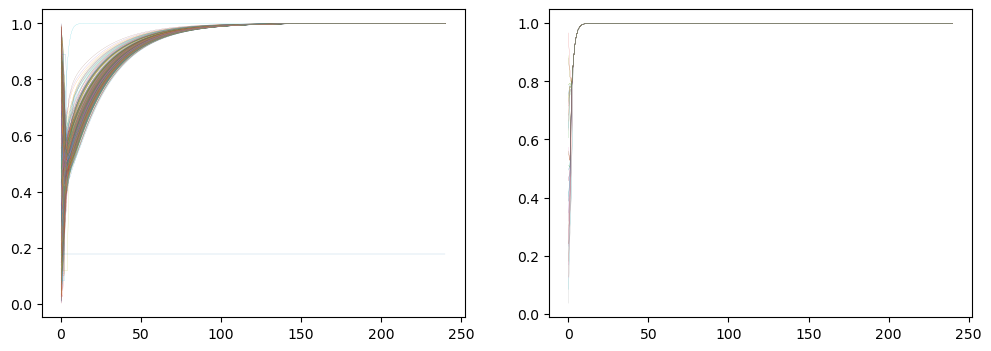

In [93]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for n_ in range(Na):
    plt.plot(opinions[:, n_], lw=0.1)
    
plt.subplot(1,2,2)
for n_ in range(Na, N):
    plt.plot(opinions[:, n_], lw=0.1)

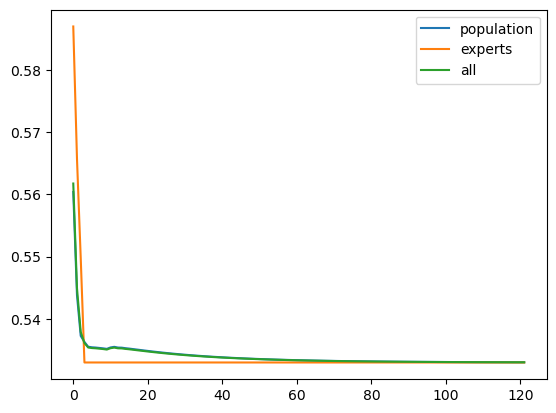

In [88]:
for rmsd, label in zip([rmsd_truth_a, rmsd_truth_e, rmsd_truth_all], ['population', 'experts', 'all']):
    plt.plot(rmsd, label=label)
    
plt.legend()